# Pythonで信号処理をやってみよう

今回は、尾本研でよく使われる、TSP信号からインパルス応答を求めるプログラムのデモをします。

## 1. TSP信号→インパルス応答

スピーカからTSP(Swept-Sine)信号を再生して、マイクで収録し、インパルス応答を求めることが多々あります。

インパルス応答は、収録されたTSP信号と再生したTSP信号の逆特性(iTSP)を円状畳み込みすると求められます。

この方法は室内音響学テキストの"SWEPT-SINE法"の節(2017年度版では7-3)に詳しく記述されています。

テキストによる、「円状畳み込みの原理を使ったインパルス応答測定法」は以下の手順で行います。

1) 所望のインパルス応答のタップ数をNとする。

2) Nより大きく、2のべき乗である長さのTSP信号を作る。

3) 同期加算を行うために、隙間なく並べる。

4) 作成した信号をスピーカで再生し、マイクで収録する。

5) 収録した信号を再生した信号長で切り取り、同期加算する。

6) 同期加算された信号にTSP信号の逆特性を円状畳み込みする。

7) これを逆FFTする。

それでは実践してみましょう。

In [1]:
# import modules
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
from modules import iowave, wavePlot
import scipy.fftpack as fft
from audioproc import sweep

### まずは、再生するTSP信号をみてみましょう。

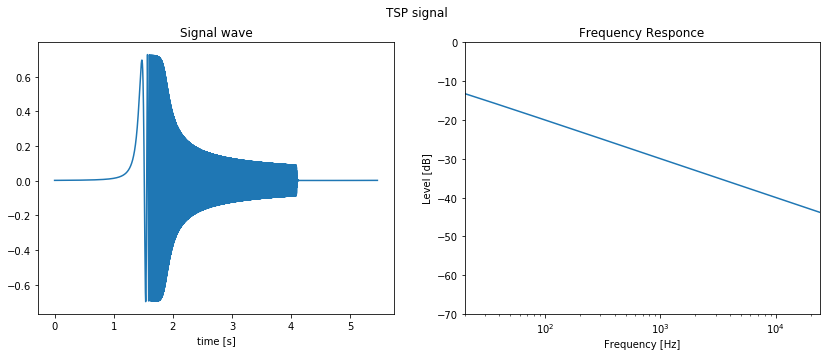

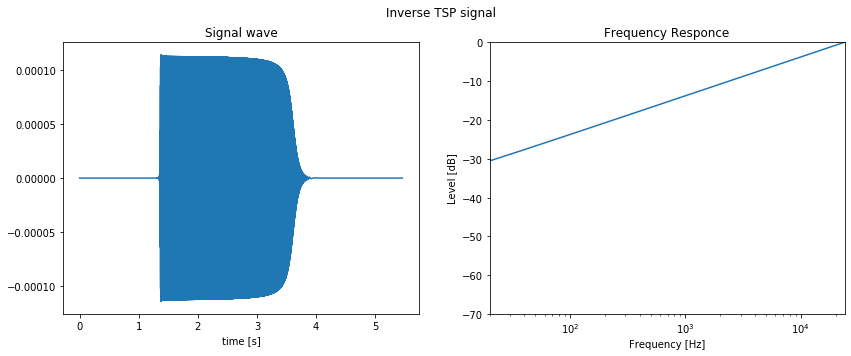

In [2]:
fs = 48000
N = 2 ** 18
J = N / 2

f = np.linspace(0, fs / 2, N // 2 + 1, endpoint=True)

# almost 1 / f
magnitude = 10. * np.log10(1. / (1. + (f / 1))) # [dB]

# -6dB/oct from over 3000 Hz
envelope = 10. * np.log10(1. / (1. + (f / 3000) ** 2)) - 3 # [dB]

tsp = sweep.gen_sweep(N, J, magnitude, envelope, plot=False, downward=False)
itsp = sweep.inverse_sweep(tsp)

wavePlot.fig_all(tsp)
plt.suptitle("TSP signal")
plt.show()
wavePlot.fig_all(itsp)
plt.suptitle("Inverse TSP signal")
plt.show()

### 同期加算するために、いくつか信号を連ねましょう。

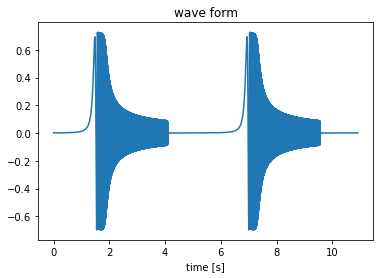

In [3]:
tsp_play = np.concatenate((tsp, tsp))
wavePlot.fig_time(tsp_play)

### 収録音源をみてみましょう。

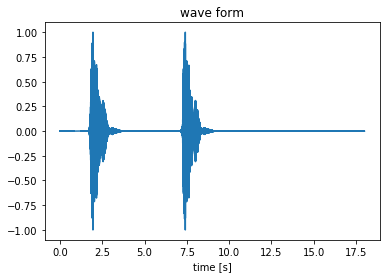

In [4]:
data_path = "/Users/watakabe/Desktop/tsp_recorded.wav" # 自分で録音した音源のパスに書き換えてください。

data = iowave.readWave(data_path)
wavePlot.fig_time(data)

### 同期加算してみましょう。

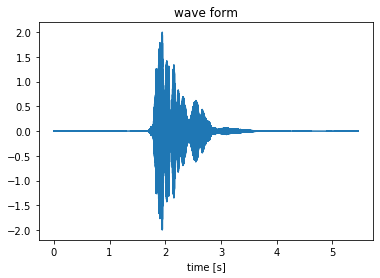

In [5]:
data_sum = data[:N] + data[N:2*N] + data[N*2:N*3]
wavePlot.fig_time(data_sum)

### 逆特性を円状畳み込みして、インパルス応答を求めましょう。

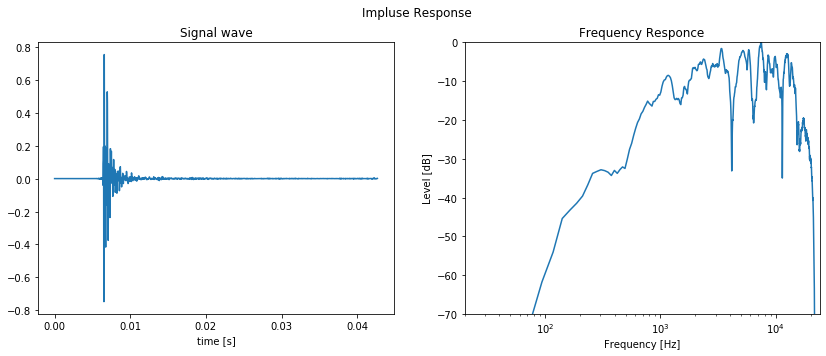

In [6]:
dataF = fft.fft(data_sum)
itspF = fft.fft(itsp)

irF = dataF * itspF
ir = fft.ifft(irF)
ir = np.real(ir)

wavePlot.fig_all(ir[:2048])
plt.suptitle("Impluse Response")
plt.show()

### できました。